'''''
{
"title": "Python Lösungen - SK-Learn Pipelines,
"keywords": "python, SK-Learn, Pipeline ",
"categories": "",
"description": "Hier werden unterschiedliche Methoden aufgezeigt wie Remote Datensätze lokal verfügbar gemacht werden können",
"level": "20",
"pageID": "15112020-SK-Learn-Pipelines-Extended"
}
'''''

# SK-Learn Pipelines

Hier der zweite Teil der SK-Learn notebooks. Nun werden die Feature einerseits mit Namen und anderseits auch per Datentyp angesprochen

In [23]:
## Bibliotheken

In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

## Data-Loading

In [25]:
labelList=['symboling','normalizedLosses','make','fuelType','aspiration','numOfDoors','bodyStyle','driveWheels','engineLocation',
           'wheelBase','length','width','height','curbWeight','engineType','numOfCylinders','engineSize','fuelSystem','bore',
           'stroke','compressionRatio','horsepower','peakRpm','cityMpg','highwayMpg','price']
df = pd.read_csv('./data_car.csv',delimiter=',',encoding='utf-8', names=labelList)
df = df.replace("?", np.nan)
df[['price']]=df[['price']].astype('float64')

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   symboling         205 non-null    int64  
 1   normalizedLosses  164 non-null    object 
 2   make              205 non-null    object 
 3   fuelType          205 non-null    object 
 4   aspiration        205 non-null    object 
 5   numOfDoors        203 non-null    object 
 6   bodyStyle         205 non-null    object 
 7   driveWheels       205 non-null    object 
 8   engineLocation    205 non-null    object 
 9   wheelBase         205 non-null    float64
 10  length            205 non-null    float64
 11  width             205 non-null    float64
 12  height            205 non-null    float64
 13  curbWeight        205 non-null    int64  
 14  engineType        205 non-null    object 
 15  numOfCylinders    205 non-null    object 
 16  engineSize        205 non-null    int64  
 1

In [27]:
output_features = [
    "symboling"
]

input_features = [
    'normalizedLosses',
    'make',
    'fuelType',
    'aspiration',
    'numOfDoors',
    'bodyStyle',
    'driveWheels',
    'engineLocation',
    'wheelBase',
    'length',
    'width',
    'height',
    'curbWeight',
    'engineType',
    'numOfCylinders',
    'engineSize',
    'fuelSystem',
    'bore',
    'stroke',
    'compressionRatio',
    'horsepower',
    'peakRpm',
    'cityMpg',
    'highwayMpg',
    'price'
]

train_X, test_X, train_y, test_y = train_test_split(
    df[input_features], 
    df[output_features],
    test_size=0.2
)

In [28]:
train_X.shape, test_X.shape, train_y.shape, test_y.shape

((164, 25), (41, 25), (164, 1), (41, 1))

In [29]:
import numpy as np

def debug_print(X, debug):
    """This method prints some debug information based on a debug parameter."""
    if not debug in ["input", "shape", "columns", False]:
        raise ValueError("Debug parameter value is not valied.")
    elif debug=="input":
        print(X.head(5))
    elif debug=="shape":
        print(X.shape)
    elif debug=="columns":
        print(X.columns)
    elif debug is False:
        pass

In [30]:
class PriceImputer():
    """Imputs Price with median price of car-Brand."""
    def __init__(self, debug=False):
        self.d = debug
        self.colnames = None
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        debug_print(X=X, debug=self.d)
        df = X.copy()
        # Es wird der durschnittliche Preis der jeweiligen Marke imputet
        df.price = df.groupby(['make'])['price'].apply(lambda x: x.fillna(x.median()))
        self.colnames = df.columns.tolist()
        return df
    
    def get_feature_names(self):
        return self.colnames 

In [31]:
class OHE():
    """OHE on the Object-Variables"""

    def __init__(self, debug=False):
        self.d = debug
        self.colnames = None
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        interimLabelListdf = X.select_dtypes(include='object')
        interimLabelList = list(interimLabelListdf.columns)
        ohe = OneHotEncoder(sparse=False)
        npArray = ohe.fit_transform(X[interimLabelList])
        titles = []
        for singleList in ohe.categories_:
            titles = titles + list(singleList)
        interimDF = pd.DataFrame(data = npArray, columns=titles)
        df = pd.concat([X, interimDF], axis=1, sort=False)
        for i in range(0,len(interimLabelList),1):
            df = df.drop([interimLabelList[i]], axis=1)
            #train_X = train_X.drop(['normalizedLosses'], axis=1)
        return df
    
    
    def get_feature_names(self):
        return self.colnames

In [32]:
from sklearn.pipeline import Pipeline

class FeaturePipeline(Pipeline):
    def get_feature_names(self):
        return self.steps[-1][1].get_feature_names()

In [33]:
# Selectoren

In [34]:
class FeatureSelector:
    """This transformer lets you pick columns from a pandas dataset based on name"""
    def __init__(self, features = [], debug=False):
        self.d = debug
        self.colnames = None
        if type(features) != list:
            raise ValueError("Input features must be of type List.")
        elif type(features) == list:
            self.columns = features

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        debug_print(X=X, debug=self.d)
        X = X[self.columns]
        self.colnames = X.columns.tolist()
        return X
    
    def get_feature_names(self):
        return self.colnames

In [38]:
# DataType
from sklearn.base import BaseEstimator, TransformerMixin
class TypeSelector(BaseEstimator, TransformerMixin):
    """This transformer lets you pick columns from a pandas dataset based on Datatype"""
    def __init__(self, dtype):
        self.dtype = dtype

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X.select_dtypes(include=[self.dtype])

In [42]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
debug_state = False
# Definition Pipeline
pipe = FeaturePipeline(
    [

        ("price_imputationName", PriceImputer(debug=False)),
        #("OHE", OHE(debug=False)),
    ]
)

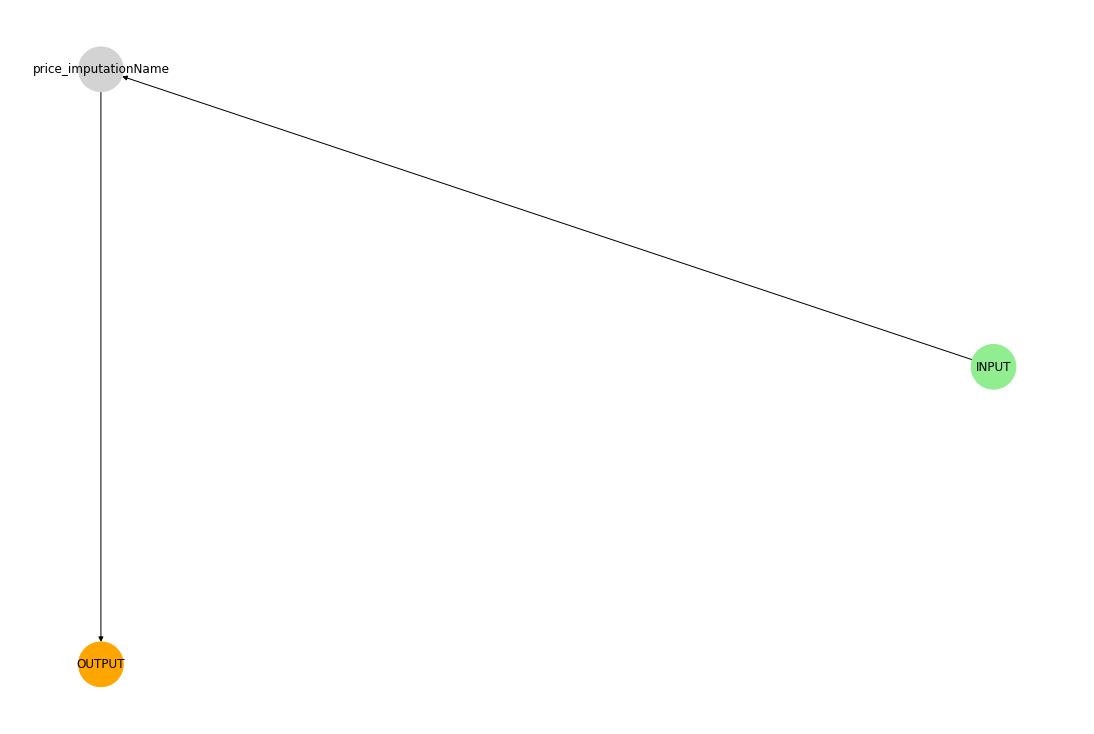

In [43]:
from pipe_tools.pipe_visualizer import plot_pipeline
plot_pipeline(pipe, "pipeline_plot.png")

In [44]:
print(train_X.price.isna().any())
print(train_X.shape)
train_X_prepared = pipe.transform(train_X)
print(train_X_prepared.price.isna().any())
print(train_X_prepared.shape)

True
(164, 25)
False
(164, 25)
